# Ear Detection and Recognition Evaluation

In [1]:
DETECTION_MODEL_PATH = 'best-fp16_final.tflite' 
IMAGE_SIZE_DETECTION = 640
IMAGE_SIZE = 224

## Detection

In [2]:
import numpy as np
labels = [[x]*7 for x in range(100)]
labels = np.array(labels)

In [3]:
def predict(save_dir='crops',save_crop=True):
  from yolov5.utils.general import non_max_suppression, scale_coords, check_img_size
  from yolov5.models.common import DetectMultiBackend
  from yolov5.utils.torch_utils import select_device
  from yolov5.utils.datasets import LoadImages
  from yolov5.utils.plots import save_one_box
  from pathlib import Path
  import torch
  import cv2

  device = select_device('')
  imgsz = [IMAGE_SIZE_DETECTION, IMAGE_SIZE_DETECTION]

  preds = []

  model = DetectMultiBackend(DETECTION_MODEL_PATH, device=device, data='yolov5/data/coco128.yaml')

  stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine

  imgsz = check_img_size(imgsz, s=stride)  # check image size

  # Half
  half = False
  half &= (pt or jit or onnx or engine) and device.type != 'cpu'  # FP16 supported on limited backends with CUDA
  if pt or jit:
    model.model.half() if half else model.model.float()

  model.warmup(imgsz=(1, 3, *imgsz))  # warmup
  
  dataset = LoadImages(DATASET_PATH, img_size=imgsz, stride=stride, auto=pt)

  for path, im, im0s, vid_cap, s in dataset:
    # Convert
    im = im.transpose((1, 2, 0))
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    im = im.transpose((2, 0, 1))
    
    im = torch.from_numpy(im).to(device)
    im = im / 255.0  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
            im = im[None]  # expand for batch dim

    pred = model(im)

    # NMS
    pred = non_max_suppression(pred, max_det=1)

    # Save cropped image
    for det in pred:  # per image
      p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)
      p = Path(p)  # to Path

      imc = im0.copy() if save_crop else im0  # for save_crop
      if len(det):
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_coords(im.shape[2:], det[:, :4], im0.shape).round()
        
        # Write results
        for *xyxy, conf, cls in reversed(det):
          f = Path(f'{save_dir}/{p.stem}.jpg')
          save_one_box(xyxy, imc, file=f, BGR=True)
      else:
        cv2.imwrite(f'{save_dir}/{p.stem}.jpg', im0)


  return preds

In [11]:
preds = predict()

YOLOv5  v6.0-224-g4c40933 torch 1.10.2+cpu CPU

Loading best-fp16_final.tflite for TensorFlow Lite inference...


In [1]:
def get_resized_dataset():
  from tensorflow import keras
  import os
  import numpy as np
  from keras.preprocessing.image import img_to_array, load_img
  import cv2

  resized_images = []
  img_folder = 'crops'
  filepaths = os.listdir(img_folder)
  filepaths.sort()
  for f in filepaths:
    if any([f.endswith(x) for x in ['.jpeg', '.jpg', '.png']]):

      image_path=os.path.join(img_folder, f)
      
      image = img_to_array(load_img(image_path))
      desired_size = IMAGE_SIZE

      old_size = image.shape[:2] # old_size is in (height, width) format

      ratio = float(desired_size)/max(old_size)
      new_size = tuple([int(x*ratio) for x in old_size])

      # new_size should be in (width, height) format

      image = cv2.resize(image, (new_size[1], new_size[0]))

      delta_w = desired_size - new_size[1]
      delta_h = desired_size - new_size[0]
      top, bottom = delta_h//2, delta_h-(delta_h//2)
      left, right = delta_w//2, delta_w-(delta_w//2)

      color = [0, 0, 0]
      new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,
          value=color)
      #new_im = cv2.cvtColor(new_im, cv2.COLOR_RGB2GRAY)
      #new_im = cv2.cvtColor(new_im, cv2.COLOR_GRAY2RGB)
      resized_images.append(img_to_array(new_im))
  return np.array(resized_images)

In [2]:
def get_awe_dataset():
  from keras.preprocessing.image import img_to_array
  import numpy as np
  import cv2
  import os
  img_folder = 'awe'
  img_data_array=[]
  labels=[]

  id = 0
  dirs = os.listdir(img_folder)
  dirs.sort()
  for dirl in dirs:
    if('.' in dirl):
      continue
    filepaths = os.listdir(os.path.join(img_folder,dirl))
    filepaths.sort()
    for file in filepaths:
      if any([file.endswith(x) for x in ['.jpeg', '.jpg', '.png']]):

        image_path=os.path.join(img_folder,dirl,file)

        image = cv2.imread(image_path)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        image = img_to_array(image)
        
        desired_size = IMAGE_SIZE

        old_size = image.shape[:2] # old_size is in (height, width) format

        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        # new_size should be in (width, height) format

        image = cv2.resize(image, (new_size[1], new_size[0]))
        

        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)

        new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
        
        new_im = img_to_array(new_im)

        #new_im = np.dot(new_im[...,:3], [0.299, 0.587, 0.114])
    
        img_data_array.append(new_im)
        labels.append(id)
    id += 1
  return np.array(img_data_array), np.array(labels)

In [8]:
def get_ami_test_dataset():
  from tensorflow import keras
  import os
  import numpy as np
  from keras.preprocessing.image import img_to_array, load_img
  import cv2

  resized_images = []
  img_folder = 'ami_test'
  filepaths = os.listdir(img_folder)
  filepaths.sort()
  for f in filepaths:
    if any([f.endswith(x) for x in ['.jpeg', '.jpg', '.png']]):

      image_path=os.path.join(img_folder, f)
      
      image = img_to_array(load_img(image_path))
      desired_size = IMAGE_SIZE

      old_size = image.shape[:2] # old_size is in (height, width) format

      ratio = float(desired_size)/max(old_size)
      new_size = tuple([int(x*ratio) for x in old_size])

      # new_size should be in (width, height) format

      image = cv2.resize(image, (new_size[1], new_size[0]))

      delta_w = desired_size - new_size[1]
      delta_h = desired_size - new_size[0]
      top, bottom = delta_h//2, delta_h-(delta_h//2)
      left, right = delta_w//2, delta_w-(delta_w//2)

      color = [0, 0, 0]
      new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
      #new_im = cv2.cvtColor(new_im, cv2.COLOR_RGB2GRAY)
      #new_im = cv2.cvtColor(new_im, cv2.COLOR_GRAY2RGB)
      resized_images.append(img_to_array(new_im))
  return np.array(resized_images)

In [13]:
cropped_dataset = get_resized_dataset()

In [3]:
awe_dataset, labels_awe = get_awe_dataset()

In [9]:
ami_test_dataset = get_ami_test_dataset()

In [10]:
ami_test_dataset.shape

(203, 224, 224, 3)

In [6]:
awe_dataset.shape

(1000, 224, 224, 3)

In [4]:
test_dataset = awe_dataset
num_identities = 100
num_templates = 10

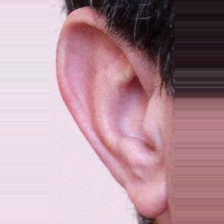

In [5]:
from keras.preprocessing.image import array_to_img
array_to_img(test_dataset[0])

## Recognition

In [6]:
class MobileRecognitionModel():
  def __init__(self):
    from tensorflow import keras
    model = keras.models.load_model('fe/model_earvn_ami')  # model
    output = model.output
    input = model.input
    self.model = keras.Model(
    inputs=input,
    outputs=output)

    model.summary()
  
  def predict(self, dataset):
    from keras.applications.mobilenet_v3 import preprocess_input
    data = preprocess_input(dataset)
    return self.model.predict(data)

In [7]:
feature_extractor = MobileRecognitionModel()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
Total params: 4,226,432
Trainable params: 0
Non-trainable params: 4,226,432
_________________________________________________________________


In [8]:
def save_tflite_model():
  import tensorflow as tf

  # Convert the model
  converter = tf.lite.TFLiteConverter.from_saved_model('fe/model_earvn_ami') # path to the SavedModel directory
  tflite_model = converter.convert()

  # Save the model.
  with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

#save_tflite_model()

In [9]:
features = feature_extractor.predict(test_dataset).reshape(test_dataset.shape[0], -1)

In [10]:
features.shape

(1000, 1280)

## Evaluation

In [11]:
def sim_matrix(features, measure='correlation'):
  import numpy as np
  if(measure == 'cosine'):
    from numpy import dot
    from numpy.linalg import norm
    fun = lambda a,b : dot(a, b)/(norm(a)*norm(b))
  else:
    from numpy import corrcoef
    fun = corrcoef
  similarityMatrix = []
  for feature in features:
    if(measure == 'cosine'):
      similarityMatrix.append(np.array([fun(feature, x) for x in features]))
    else:
      return fun(features)
  return np.array(similarityMatrix)

In [12]:
distance_matrix_cos = sim_matrix(features, 'cosine')
distance_matrix_corr = sim_matrix(features)
distance_matrix_corr.shape, distance_matrix_cos.shape

((1000, 1000), (1000, 1000))

In [13]:
def confusion_matrix(threshold, sim_matrix, n_identities=100, n_templates=7):
  import numpy as np
  conf_matrix = np.zeros((2,2)) #[[ GA FR ]
                                # [ FA GR ]]
  nrows = sim_matrix.shape[0]
  ids = range(0, n_identities)
  for row in range(nrows):
    for id in ids:
      elems = np.arange(id * n_templates, (id + 1) * n_templates)
      m_label = sim_matrix[row, elems[np.where(elems!=row)]]
      if(m_label.max() > threshold):
        if(id == row//n_templates):
          conf_matrix[0,0] += 1       # GA
        else: 
          conf_matrix[1,0] += 1   # FA
      elif(id == row//n_templates):  
        conf_matrix[0,1] += 1         # FR
      else:
        conf_matrix[1,1] += 1         # GR
  
  return conf_matrix

conf_matrix_corr = confusion_matrix(0.98, distance_matrix_corr[:,:], n_identities=num_identities)
conf_matrix_cos = confusion_matrix(0.98, distance_matrix_cos[:,:], n_identities=num_templates)

In [14]:
def genuine_impostor_scores(sim_matrix, n_identities=100, n_templates=7):
  import numpy as np
  genuine_scores = []
  impostor_scores = []
  nrows = sim_matrix.shape[0]
  for row in range(nrows):
    for id in range(n_identities):
      elems = np.arange(id * n_templates, (id + 1) * n_templates)
      m_label = sim_matrix[row, elems[np.where(elems!=row)]]
      if(id == row//n_templates): # genuine
        genuine_scores.append(m_label)
      else:                       # impostor
        impostor_scores.append(m_label)

  return np.array(genuine_scores).flatten(), np.array(impostor_scores).flatten()

In [15]:
genuine_scores_corr, impostor_scores_corr = genuine_impostor_scores(distance_matrix_corr, n_templates=num_templates, n_identities=num_identities)
genuine_scores_corr.shape, impostor_scores_corr.shape

((9000,), (990000,))

In [16]:
genuine_scores_cos, impostor_scores_cos = genuine_impostor_scores(distance_matrix_cos, n_templates=num_templates, n_identities=num_identities)
genuine_scores_cos.shape, impostor_scores_cos.shape

((9000,), (990000,))

In [17]:
from pyeer.pyeer.eer_info import get_eer_stats
stats_corr = get_eer_stats(genuine_scores_corr, impostor_scores_corr, ds_scores=False)

In [18]:
stats_cos = get_eer_stats(genuine_scores_cos, impostor_scores_cos,ds_scores=False)

In [19]:
from pyeer.pyeer.plot import plot_eer_stats
plot_eer_stats([stats_corr, stats_cos], ['fe_mobile_corr', 'fe_mobile_cos'], save_plots=True, lgf_size=10, dpi=1000, bins=200, save_path='./scores/', ext='.jpg')

In [20]:
def get_stats(dist_matrix):
  import numpy as np
  n_rows = dist_matrix.shape[0]
  n_cols = dist_matrix.shape[1]
  stats=np.empty((n_rows, n_cols-1, 3))
  for row in range(n_rows):
    for col in range(n_cols):
        if(row!=col):
          dist = dist_matrix[row, col]
          
          i = row
          j = col
          
          if(j>=i):
            j -= 1

          stats[i,j,0] = row
          stats[i,j,1] = col
          stats[i, j, 2] = dist

  return stats.reshape(-1, 3)

In [21]:
def get_tp(dist_matrix, n_templates=7):
  import numpy as np
  n_rows = dist_matrix.shape[0]
  stride = n_templates-1
  tp = np.empty((n_rows * stride, 2))

  for row in range(n_rows):
    id = row // n_templates
    elems = np.arange(id * n_templates, (id + 1) * n_templates)

    elems = elems[np.where(elems!=row)]
    
    for i, elem in enumerate(elems):
      tp[row*stride+i, 0] = row
      tp[row*stride+i, 1] = elem
  return tp

In [22]:
tp_corr = get_tp(distance_matrix_corr, n_templates=num_templates)
stats_corr = get_stats(distance_matrix_corr)
stats_corr.shape, tp_corr.shape

((999000, 3), (9000, 2))

In [23]:
tp_cos = get_tp(distance_matrix_cos, n_templates=num_templates)
stats_cos = get_stats(distance_matrix_cos)
stats_cos.shape, tp_cos.shape

((999000, 3), (9000, 2))

In [24]:
def calc_scores(stats, tp, ds_scores=False):
  import operator

  SCORE_POS = 1
  TEMPLATE_POS = 0

  matching_scores = {}
  for row in tp:
    query, template = row
    if query in matching_scores:
      matching_scores[query][TEMPLATE_POS].append(template)
    else:
      matching_scores[query] = ([template], [])
  
  for row in stats:
    query, template, score = row
    matching_scores[query][SCORE_POS].append((template, score))

  for query_match_info in matching_scores.values():
        query_match_info[SCORE_POS].sort(key=operator.itemgetter(1),
                                        reverse=not ds_scores)
  return matching_scores

In [25]:
from pyeer.pyeer.cmc_stats import get_cmc_curve, CMCstats
from pyeer.pyeer.plot import plot_cmc_stats

scores_corr = calc_scores(stats_corr, tp_corr)
scores_cos = calc_scores(stats_cos, tp_cos)

In [ ]:
r=10

# Calculating CMC curve
ranks_corr = get_cmc_curve(scores_corr, r)
ranks_cos = get_cmc_curve(scores_cos, r)

# Creating stats
stats = [CMCstats(exp_id='FE_256_corr', ranks=ranks_corr), CMCstats(exp_id='FE_256_cos', ranks=ranks_cos)]

# Plotting
plot_cmc_stats(stats, r, save_plots=True, lgf_size=10, dpi=1000, save_path='./scores/', ext='.jpg')